# Transforming multivariate time series into images

In this notebook, we will try to have a look at different strategies to transform a mutlivariate time series into a single image or a set of images.

In [1]:
! pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 6.8 MB/s 


In [2]:
# Load all the necessary packages, classes and functions.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable
import numpy as np
from pyts.datasets import load_basic_motions
from pyts.image import GramianAngularField
from pyts.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

### Data: first time series in the "basic motions" dataset

In [3]:
# Get the first multivariate time series in the "Basic motions" dataset
X, _, _, _ = load_basic_motions(return_X_y=True)
x = X[0]
n_features, n_timestamps = x.shape

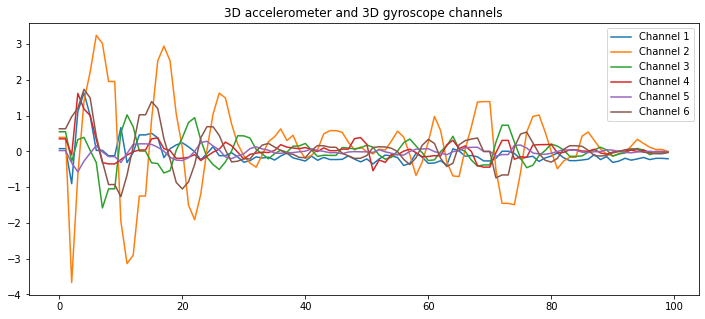

In [7]:
# Plot the multivariate time series
plt.figure(figsize=(12, 5))
for i in range(n_features):
    plt.plot(x[i], label=f'Channel {i + 1}')
plt.legend()
plt.title('3D accelerometer and 3D gyroscope channels')
plt.show()

### Independent gramian angular fields

We will compute a Gramian Angular Field for each feature (i.e. channel) independently and have a look at the corresponding images.

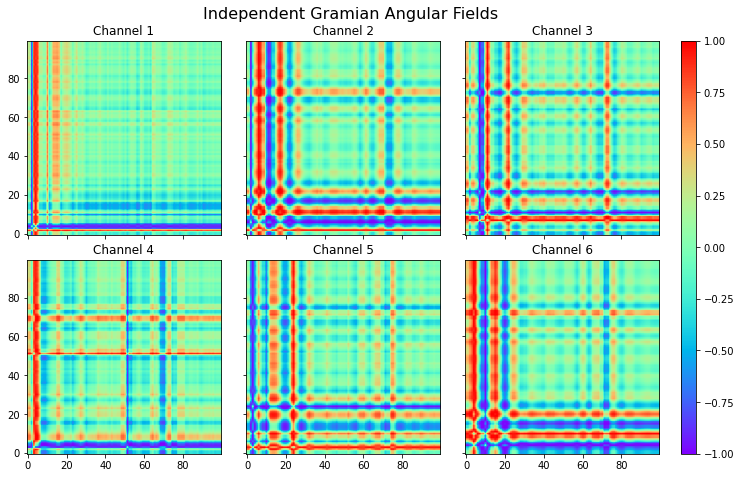

In [8]:
# Compute one GAF for each feature independently
gaf = GramianAngularField(method='d')
x_gaf = gaf.fit_transform(x)

# Plot the corresponding images
fig = plt.figure(figsize=(12, 8))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 3),
                 axes_pad=0.35,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="4%",
                 cbar_pad=0.3,
                 )
titles = [f'Channel {i}' for i in range(1, 7)]
for image, title, ax in zip(x_gaf, titles, grid):
    im = ax.imshow(image, cmap='rainbow', origin='lower', vmin=-1, vmax=1)
    ax.set_title(title, fontdict={'fontsize': 12})
plt.colorbar(im, cax=grid.cbar_axes[0])
plt.suptitle('Independent Gramian Angular Fields', y=0.92, fontsize=16)
plt.subplots_adjust(hspace=0.8)

### Single image based on cosine similarity

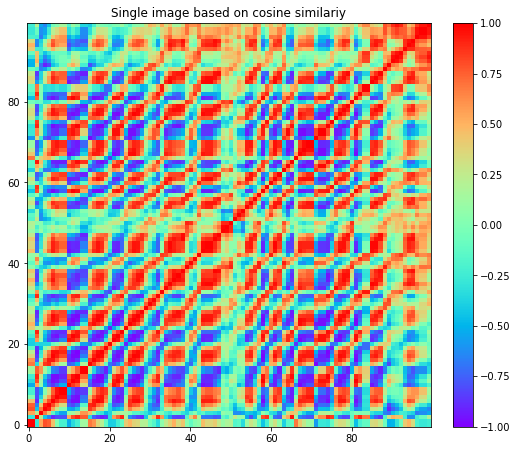

In [ ]:
# Compute the cosine similarity between all the timepoints.
# Each timepoint is represented by a vector with all the features.
x_cosine = cosine_similarity(x.T)

# Plot the corresponding image
plt.figure(figsize=(8, 8))
plt.imshow(x_cosine, cmap='rainbow', origin='lower', vmin=-1, vmax=1)
plt.colorbar(fraction=0.0452)
plt.title('Single image based on cosine similariy', fontsize=12)
plt.show()

We can see that the range of colors looks similar to the second channel of the multivariate time series.
This is because this channel has a higher scale than the other channels, and thus contributes more to the cosine similarity scores than the other channels.
To alleviate this issue, we will standardize (zero mean, unit variance) each channel independently.

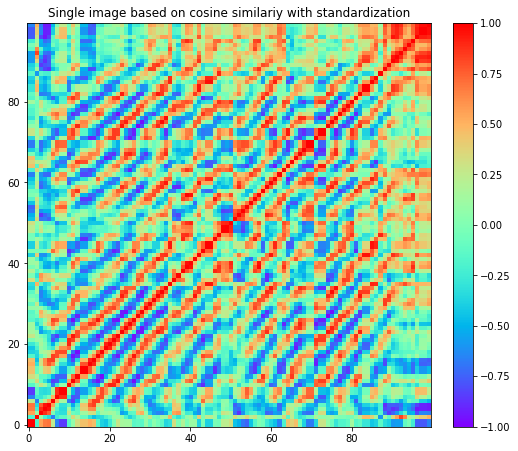

In [ ]:
scaler = StandardScaler()
x_scaled = scaler.transform(x)
x_scaled_cosine = cosine_similarity(x_scaled.T)

# Plot the corresponding image
plt.figure(figsize=(8, 8))
plt.imshow(x_scaled_cosine, cmap='rainbow', origin='lower', vmin=-1, vmax=1)
plt.colorbar(fraction=0.0452)
plt.title('Single image based on cosine similariy with standardization', fontsize=12)
plt.show()

This new image relies less on the second channel, which is good.
Nonetheless, we can see that we obtain a very different image than the independent GAF images.
The cosine similarity uses the norm of both vectors (at two given time points) to normalize the score, which does not take into account the range of values over all the time points.
We should try to use a different kind of normalization.
First, we will only compute the dot product using the [sklearn.metrics.pairwise.linear_kernel](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.linear_kernel.html#sklearn.metrics.pairwise.linear_kernel) function.
Then, we will normalize the image so that its minimum value is -1 and its maximum value is +1.

### Single image based on linear kernel with transformation

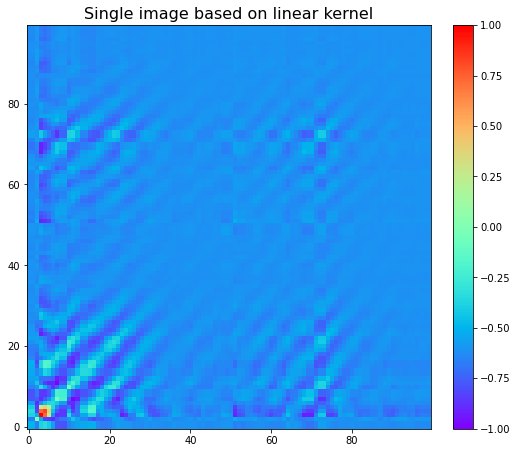

In [ ]:
x_dot = linear_kernel(x_scaled.T)
x_dot_normalized = 2 * (x_dot - x_dot.min()) / (x_dot.max() - x_dot.min()) - 1

# Plot the corresponding image
plt.figure(figsize=(8, 8))
plt.imshow(x_dot_normalized, cmap='rainbow', origin='lower', vmin=-1, vmax=1)
plt.colorbar(fraction=0.0452)
plt.title('Single image based on linear kernel', fontsize=16)
plt.show()

The resulting image is unsatisfying.
Let's have a look at the distribution of the dot product values.

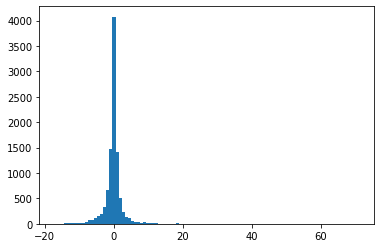

In [ ]:
plt.hist(x_dot.ravel(), bins=100);

In [ ]:
x_dot.min(), x_dot.max()

(-17.119794994857816, 71.11714869845946)

We can see that we have outliers that make this linear normalization based on the minimum and maximum values unsuitable.

Let's try a non-linear transformation based on quantiles to map the data into a uniform distribution.

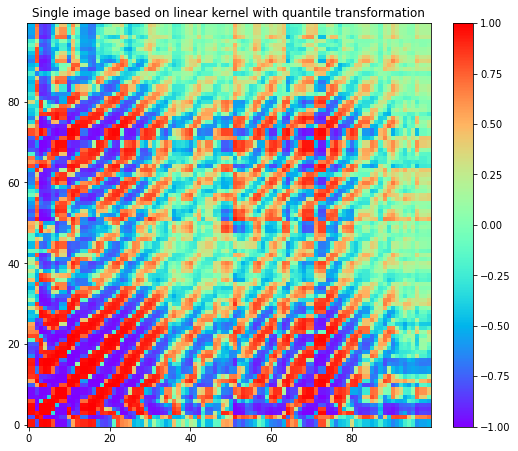

In [ ]:
quantile = QuantileTransformer()
x_dot_quantile = 2 * quantile.transform(x_dot.reshape(1, -1)).reshape((n_timestamps, n_timestamps)) - 1

# Plot the corresponding image
plt.figure(figsize=(8, 8))
plt.imshow(x_dot_quantile, cmap='rainbow', origin='lower', vmin=-1, vmax=1)
plt.colorbar(fraction=0.0452)
plt.title('Single image based on linear kernel with quantile transformation', fontsize=12)
plt.show()

The resulting image is more satisfying and closer to the independant GAF images.

Let's try with a mapping to a normal distribution followed by a linear normalization to range (-1, 1).

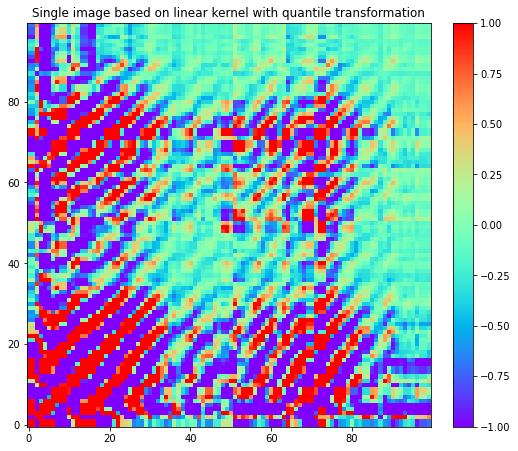

In [ ]:
power = PowerTransformer()
x_dot_power = power.transform(x_dot.reshape(1, -1)).reshape((n_timestamps, n_timestamps))
x_dot_power = 2 * (x_dot_power - x_dot_power.min() / (x_dot_power.max() - x_dot_power.min())) - 1

# Plot the corresponding image
plt.figure(figsize=(8, 8))
plt.imshow(x_dot_power, cmap='rainbow', origin='lower', vmin=-1, vmax=1)
plt.colorbar(fraction=0.0452)
plt.title('Single image based on linear kernel with quantile transformation', fontsize=12)
plt.show()

The resulting image is very similar to the previous one.